<a href="https://colab.research.google.com/github/mchchoi/factorization/blob/main/Swapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:176: SyntaxWarning: invalid escape sequence '\p'
<>:177: SyntaxWarning: invalid escape sequence '\p'
<>:176: SyntaxWarning: invalid escape sequence '\p'
<>:177: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-1746872438.py:176: SyntaxWarning: invalid escape sequence '\p'
  hist_with_pi(cold_Psw[burn:],   "Histogram: $P_{sw}$ (last coordinate) vs $\pi_{β}$",        r"$P_{sw}$")
/tmp/ipython-input-1746872438.py:177: SyntaxWarning: invalid escape sequence '\p'
  hist_with_pi(cold_Pswm1[burn:], "Histogram: $P_{sw}^{(-1)}$ (last coordinate) vs $\pi_{β}$", r"$P_{sw}^{(-1)}$")


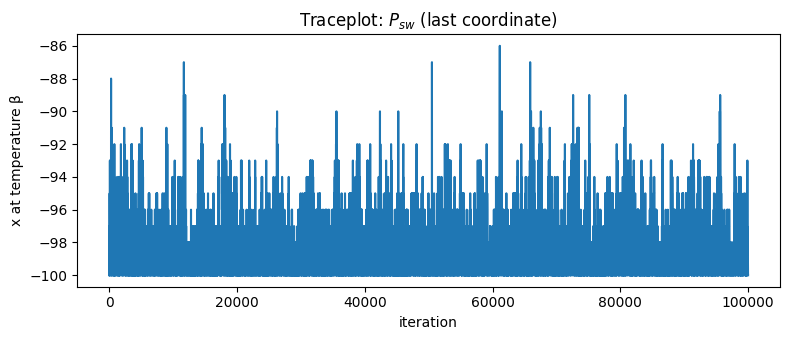

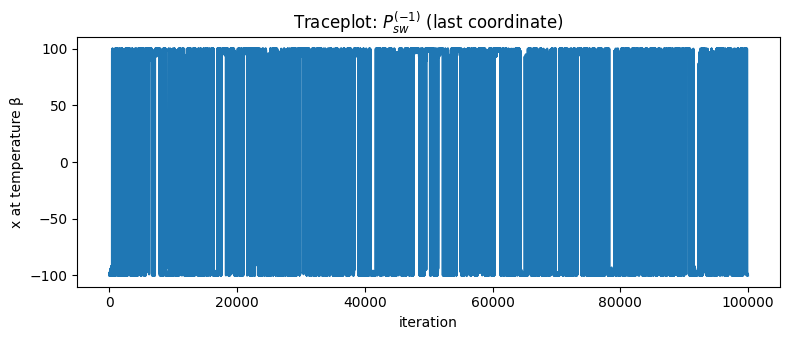

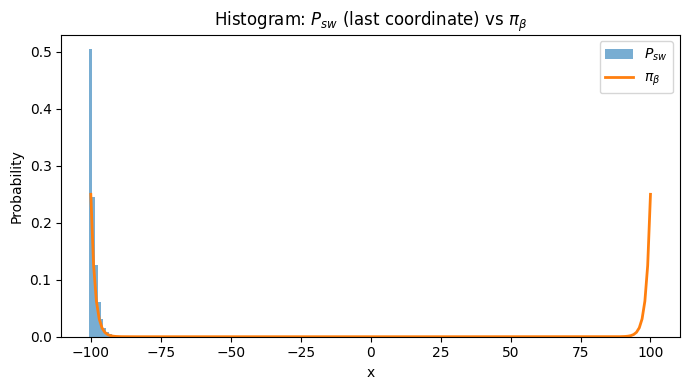

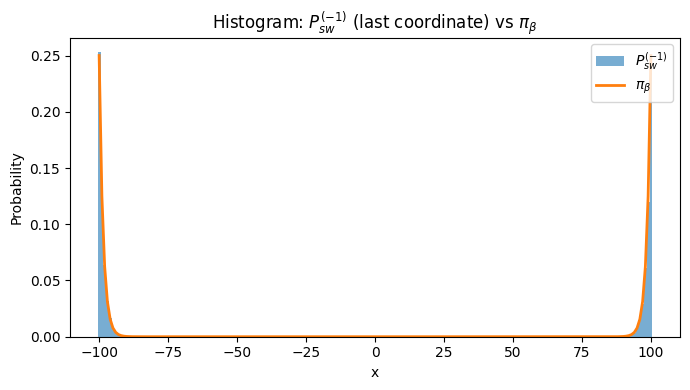


Mean & Second Moment vs Truth (Cold Chain):
     Sampler      Mean  Second moment  ΔMean (emp - true)  ΔSecond (emp - true)
       P_sw -99.00947    9804.852709           -99.00947              1.852709
P_sw^{(-1)}  -2.01179    9804.270553            -2.01179              1.270553
  Truth π_β   0.00000    9803.000000             0.00000              0.000000

TV & KL to Truth:
     Sampler       TV  KL(emp || truth)
       P_sw 0.500039          0.693507
P_sw^{(-1)} 0.011123          0.000899

Swap moves: 50090, accepted: 18307 (0.365 acceptance). Level moves: 49909.


In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Swapping algorithm P_sw vs projected leave-{1}-out P_sw^{(-1)} on X = {-n,...,n}.
Target: π_β(x) ∝ 2^{|x|} = exp(β |x|) with β = ln 2 and H(x) = -|x|.
We compare the cold-chain (β_d) marginal.

Produces:
  • Traceplots (first trace_len iters) for P_sw and P_sw^{(-1)} cold coordinate
  • Histograms (post burn-in) overlaid with π_β (legend upper right)
  • Table: empirical mean & second moment vs truth
  • Table: TV and KL(emp || truth)
  • Saves CSVs alongside the script
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple

# ---------------- Configuration (you can edit these) ----------------
SEED = 42
rng = np.random.default_rng(SEED)

n = 100               # state space: {-n, ..., n}
d = 3                # number of temperatures
beta = float(np.log(2.0))
T = 100000            # total iterations
burn = 1          # burn-in for hist/tables
trace_len = 100000     # iterations shown in trace plots

# Temperature ladder 0 = β_1 < ... < β_d = β
betas = np.linspace(0.0, beta, d)

# ---------------- Model & helpers ----------------
xs = np.arange(-n, n+1)

def H(x: int) -> int:
    """Energy: H(x) = -|x|."""
    return -abs(x)

def clip_state(x: int) -> int:
    return int(np.clip(x, -n, n))

# Target π_β on X (for plotting and truth stats)
w_beta = np.exp(betas[-1] * np.abs(xs))   # since π_β ∝ e^{-βH} with H=-|x|
pi_beta = w_beta / w_beta.sum()

# π_0 is uniform on X
def sample_from_pi0() -> int:
    k = rng.integers(0, len(xs))
    return int(xs[k])

# Local proposal at one temperature: ±1 random walk with reflecting boundaries
def propose_M(x: int) -> int:
    step = 1 if rng.random() < 0.5 else -1
    return clip_state(x + step)

def mh_single_temp(x: int, beta_val: float) -> Tuple[int, bool]:
    """One MH step at inverse temperature beta_val targeting π_β(x) ∝ exp(beta_val*|x|)."""
    y = propose_M(x)
    log_alpha = beta_val * (abs(y) - abs(x))
    if log_alpha >= 0 or rng.random() < np.exp(log_alpha):
        return y, (y != x)
    return x, False

# ---------------- Swapping kernel P_sw ----------------
def swap_accept(x_i: int, x_j: int, beta_i: float, beta_j: float) -> float:
    """
    Acceptance ratio for swapping positions at neighboring temperatures β_i, β_j.
    Ratio = exp( (β_j - β_i) * (H(x_j) - H(x_i)) ).
    """
    delta = (beta_j - beta_i) * (H(x_j) - H(x_i))
    return 1.0 if delta >= 0 else float(np.exp(delta))

def p_sw_step(state: np.ndarray):
    """
    One step of P_sw on X^d.
    With prob 1/2: level move at a random temperature (one MH step at that β).
    With prob 1/2: swap move between a random adjacent pair (i,i+1) with MH acceptance.
    Returns (new_state, move_type, aux_info).
    """
    s = state.copy()
    if rng.random() < 0.5:
        # Level move
        i = rng.integers(0, d)  # choose a level uniformly
        s[i], _ = mh_single_temp(s[i], betas[i])
        return s, "level", {}
    else:
        # Swap move
        i = rng.integers(0, d-1)  # choose adjacent pair
        a = swap_accept(s[i], s[i+1], betas[i], betas[i+1])
        acc = 0
        if rng.random() < a:
            s[i], s[i+1] = s[i+1], s[i]
            acc = 1
        return s, "swap", {"swap_accepted": acc, "pair": int(i)}

# ---------------- Projected leave-{1}-out kernel P_sw^{(-1)} ----------------
def p_sw_minus1_step(state_minus1: np.ndarray) -> np.ndarray:
    """
    Given current (x_2,...,x_d), sample x_1 ~ π_0 (uniform),
    apply one P_sw step to the full vector (x_1,...,x_d),
    return only the last d-1 coords (x_2',...,x_d').
    """
    x1 = sample_from_pi0()
    full = np.empty(d, dtype=int)
    full[0] = x1
    full[1:] = state_minus1
    full_new, _, _ = p_sw_step(full)
    return full_new[1:]

# ---------------- Simulations ----------------
def simulate_Psw(x0_full: np.ndarray):
    chain = np.empty((T, d), dtype=int)
    chain[0] = x0_full
    stats = {"swap": 0, "swap_accept": 0, "level": 0}
    for t in range(1, T):
        new_state, move, aux = p_sw_step(chain[t-1])
        chain[t] = new_state
        if move == "swap":
            stats["swap"] += 1
            stats["swap_accept"] += aux.get("swap_accepted", 0)
        else:
            stats["level"] += 1
    return chain, stats

def simulate_Psw_minus1(x0_minus1: np.ndarray):
    chain = np.empty((T, d-1), dtype=int)
    chain[0] = x0_minus1
    for t in range(1, T):
        chain[t] = p_sw_minus1_step(chain[t-1])
    return chain

# Initial states (simple choice)
x0_full = (-n)*np.ones(d, dtype=int)
x0_minus1 = (-n)*np.ones(d-1, dtype=int)

Psw_chain, Psw_stats = simulate_Psw(x0_full)
Pswm1_chain = simulate_Psw_minus1(x0_minus1)

# Extract cold coordinate (β_d = β)
cold_idx_full = d - 1        # index in full state
cold_idx_minus1 = d - 2      # index in the (d-1)-vector
cold_Psw = Psw_chain[:, cold_idx_full]
cold_Pswm1 = Pswm1_chain[:, cold_idx_minus1]

# ---------------- Traceplots ----------------
def traceplot(series: np.ndarray, title: str):
    plt.figure(figsize=(8, 3.5))
    L = min(trace_len, len(series))
    plt.plot(np.arange(L), series[:L])
    plt.xlabel("iteration")
    plt.ylabel("x at temperature β")
    plt.title(title)
    plt.tight_layout()
    plt.show()

traceplot(cold_Psw,   "Traceplot: $P_{sw}$ (last coordinate)")
traceplot(cold_Pswm1, "Traceplot: $P_{sw}^{(-1)}$ (last coordinate)")

# ---------------- Histograms with truth overlay ----------------
bins = np.arange(-n - 0.5, n + 1.5, 1.0)

def hist_with_pi(samples: np.ndarray, title: str, emp_label: str):
    plt.figure(figsize=(7, 4))
    plt.hist(samples, bins=bins, density=True, alpha=0.6, label=emp_label)
    plt.plot(xs, pi_beta, linewidth=2, label=r"$\pi_{\beta}$")
    plt.xlabel("x")
    plt.ylabel("Probability")
    plt.title(title)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

hist_with_pi(cold_Psw[burn:],   "Histogram: $P_{sw}$ (last coordinate) vs $\pi_{β}$",        r"$P_{sw}$")
hist_with_pi(cold_Pswm1[burn:], "Histogram: $P_{sw}^{(-1)}$ (last coordinate) vs $\pi_{β}$", r"$P_{sw}^{(-1)}$")

# ---------------- Tables: moments and divergences ----------------
def summarize_mean_second(samples: np.ndarray) -> Tuple[float, float]:
    s = samples.astype(float)
    return float(np.mean(s)), float(np.mean(s**2))

mu_true     = float(np.sum(xs * pi_beta))
second_true = float(np.sum((xs**2) * pi_beta))

m1_sw, m2_sw     = summarize_mean_second(cold_Psw[burn:])
m1_proj, m2_proj = summarize_mean_second(cold_Pswm1[burn:])

df_mom = pd.DataFrame([
    ["P_sw",      m1_sw,   m2_sw,   m1_sw - mu_true,   m2_sw - second_true],
    ["P_sw^{(-1)}", m1_proj, m2_proj, m1_proj - mu_true, m2_proj - second_true],
    ["Truth π_β",        mu_true, second_true, 0.0, 0.0],
], columns=["Sampler", "Mean", "Second moment", "ΔMean (emp - true)", "ΔSecond (emp - true)"]).round(6)

print("\nMean & Second Moment vs Truth (Cold Chain):\n", df_mom.to_string(index=False))
df_mom.to_csv("swapping_mean_second_moment.csv", index=False)

# Empirical pmf and distances (TV, KL(emp||truth))
def empirical_pmf(samples: np.ndarray, support: np.ndarray) -> np.ndarray:
    counts = np.bincount(samples - support[0], minlength=len(support)).astype(float)
    return counts / counts.sum()

def tv_dist(p, q) -> float:
    return 0.5 * float(np.abs(p - q).sum())

def kl_emp_true(p, q) -> float:
    mask = p > 0
    return float(np.sum(p[mask] * (np.log(p[mask]) - np.log(q[mask]))))

p_sw   = empirical_pmf(cold_Psw[burn:],   xs)
p_proj = empirical_pmf(cold_Pswm1[burn:], xs)

df_div = pd.DataFrame([
    ["P_sw",      tv_dist(p_sw,   pi_beta), kl_emp_true(p_sw,   pi_beta)],
    ["P_sw^{(-1)}", tv_dist(p_proj, pi_beta), kl_emp_true(p_proj, pi_beta)],
], columns=["Sampler", "TV", "KL(emp || truth)"]).round(6)

print("\nTV & KL to Truth:\n", df_div.to_string(index=False))
df_div.to_csv("swapping_tv_kl.csv", index=False)

# Optional: print some quick swap stats
if Psw_stats["swap"] > 0:
    acc_rate = Psw_stats["swap_accept"] / Psw_stats["swap"]
    print(f"\nSwap moves: {Psw_stats['swap']}, accepted: {Psw_stats['swap_accept']} "
          f"({acc_rate:.3f} acceptance). Level moves: {Psw_stats['level']}.")


In [14]:
0.6931/2

0.34655